In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load merge CSV file
df = pd.read_csv("Merge_file.csv")

df = df.dropna()

df.head()

,coin,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


Now we introduce new feature called volume exchange per marcket capital which might saperate high volume exchange with low capital.

In [3]:
#make a new feature of volume per capital that we called ratio

df['ratio'] = df['24h_volume']/df['mkt_cap']

df.head()

,coin,price,1h,24h,7d,24h_volume,mkt_cap,date,ratio
0,Bitcoin,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16,0.045903
1,Ethereum,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16,0.060374
2,Tether,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16,0.724503
3,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16,0.021795
4,USD Coin,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16,0.074150


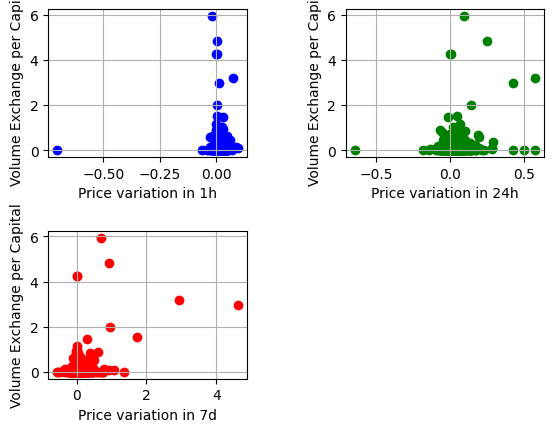

In [4]:
plt.Figure(figsize=(12,5))
#plt.title('Price Variation VS Volume Exchange per Marcket Capital', loc='center')

plt.subplot(2,2,1)
plt.scatter(df['1h'],df['ratio'], c='blue')
plt.ylabel('Volume Exchange per Capital')
plt.xlabel('Price variation in 1h')
plt.grid()

plt.subplot(2,2,2)
plt.scatter(df['24h'],df['ratio'], color='green')
plt.ylabel('Volume Exchange per Capital')
plt.xlabel('Price variation in 24h')
plt.grid()

plt.subplot(2,2,3)
plt.scatter(df['7d'],df['ratio'], color='red')
plt.ylabel('Volume Exchange per Capital')
plt.xlabel('Price variation in 7d')
plt.grid()

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

There are some data points which are out of the clusters Also, shows zero variation in price while the volume exchange per capital is very large. This data points are outlier but that could be not in high risk of marcket stability.

In [5]:
# Final feature set
features = [ "price", "1h", "24h", "7d", "ratio"]
X = df[features]

In [6]:
from sklearn.decomposition import PCA

#Reducing the columns 1h, 24h, 7d in one
data_for_pca = X[["1h", "24h", "7d"]]

# Initialize PCA to reduce to 1 components
pca = PCA(n_components=1)

variation = pca.fit_transform(data_for_pca)

X['variation'] = variation
X.drop(['1h', '24h', '7d'],  axis=1, inplace=True)


In [7]:
from sklearn.preprocessing import StandardScaler
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[ 9.10441513, -0.15502394,  0.1388917 ],
       [ 0.48064912, -0.11532614,  0.18408456],
       [-0.14006438,  1.70650975, -0.11552839],
       ...,
       [-0.14027502,  0.27098165, -0.26896606],
       [-0.14018551,  0.10163217, -0.02599834],
       [-0.14006451, -0.28011857, -0.59985346]], shape=(992, 3))

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

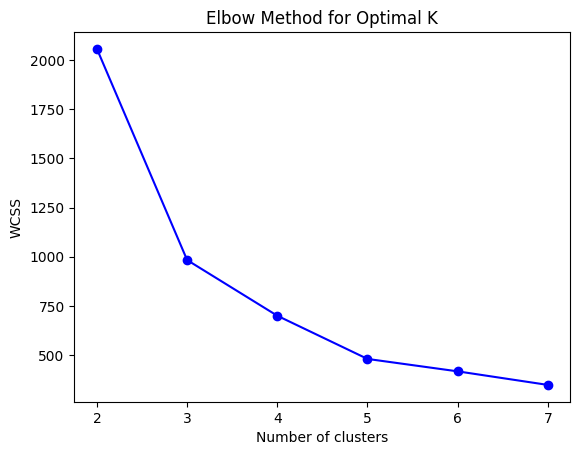

In [9]:
# K-Means Clustering

# Find optimal k (Elbow Method)
wcss = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(K, wcss, 'bo-')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()


Silhouette Score (KMeans): 0.9182266817270094


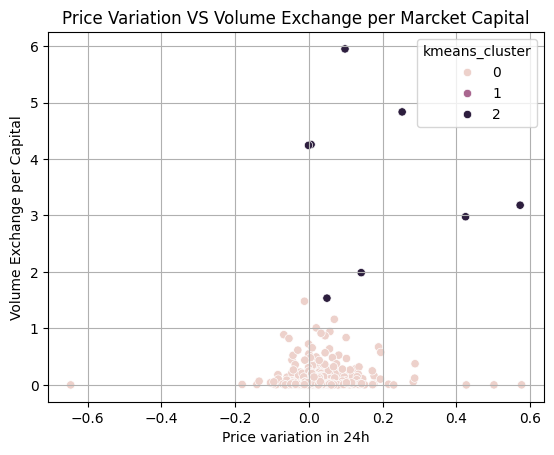

In [10]:
#Fit KMeans with chosen k=3
kmeans = KMeans(n_clusters=3, random_state=1)
df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# Silhouette score
score1 = silhouette_score(X_scaled, df["kmeans_cluster"])
print("Silhouette Score (KMeans):", score1)

plt.Figure(figsize=(12,5))
plt.title('Price Variation VS Volume Exchange per Marcket Capital', loc='center')
sns.scatterplot(data=df, x='24h',y='ratio', hue='kmeans_cluster')
plt.ylabel('Volume Exchange per Capital')
plt.xlabel('Price variation in 24h')
plt.grid()

plt.show()

dbscan_cluster
 0    967
-1     25
Name: count, dtype: int64
Silhouette Score (DBSCAN): 0.9070002406715184


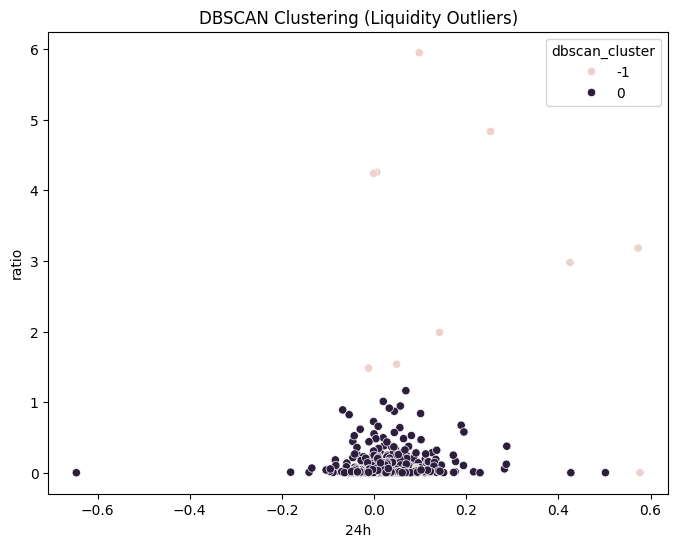

In [11]:
#DBSCAN (to detect anomalies/outliers)

db = DBSCAN(eps=1.5, min_samples=20)
df["dbscan_cluster"] = db.fit_predict(X_scaled)

# Check number of clusters (-1 means outliers)
print(df["dbscan_cluster"].value_counts())

# Silhouette score
score2 = silhouette_score(X_scaled, df["dbscan_cluster"])
print("Silhouette Score (DBSCAN):", score2)

# Plot DBSCAN results
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, y="ratio", x="24h", hue="dbscan_cluster")
plt.title("DBSCAN Clustering (Liquidity Outliers)")
plt.show()

iso_outlier
 1    942
-1     50
Name: count, dtype: int64
Anomalous coins (liquidity outliers):
               coin     ratio    24h_volume       mkt_cap    24h
0           Bitcoin  0.045903  3.539076e+10  7.709915e+11  0.030
1          Ethereum  0.060374  1.974870e+10  3.271044e+11  0.034
15  Wrapped Bitcoin  0.039995  4.430456e+08  1.107764e+10  0.030
47            Waves  0.526901  1.508088e+09  2.862186e+09  0.081
54        THORChain  0.137560  2.978361e+08  2.165143e+09 -0.059


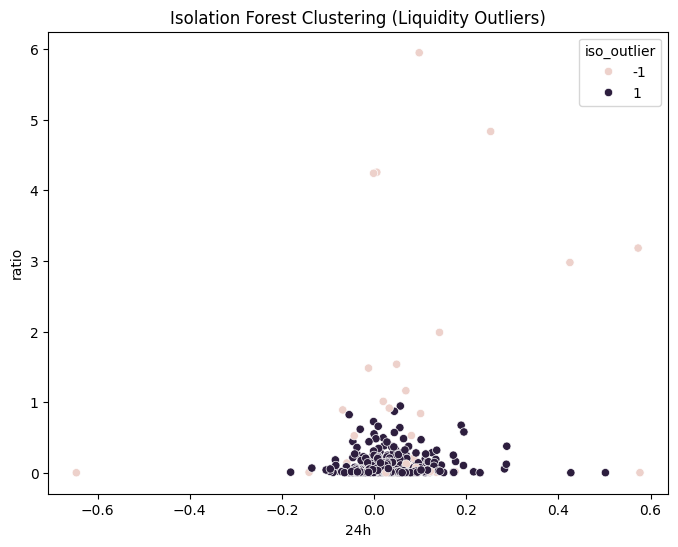

In [12]:
from sklearn.ensemble import IsolationForest

# Isolation Forest (Anomaly Detection)

iso = IsolationForest(contamination=0.05, random_state=1)
df["iso_outlier"] = iso.fit_predict(X_scaled)

# -1 = outlier, 1 = normal
print(df["iso_outlier"].value_counts())

# Mark anomalies
outliers = df[df["iso_outlier"] == -1]
print("Anomalous coins (liquidity outliers):")
print(outliers[["coin", "ratio", "24h_volume", "mkt_cap", "24h"]].head())

# Plot Isolation Forest results
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, y="ratio", x="24h", hue="iso_outlier")
plt.title("Isolation Forest Clustering (Liquidity Outliers)")
plt.show()


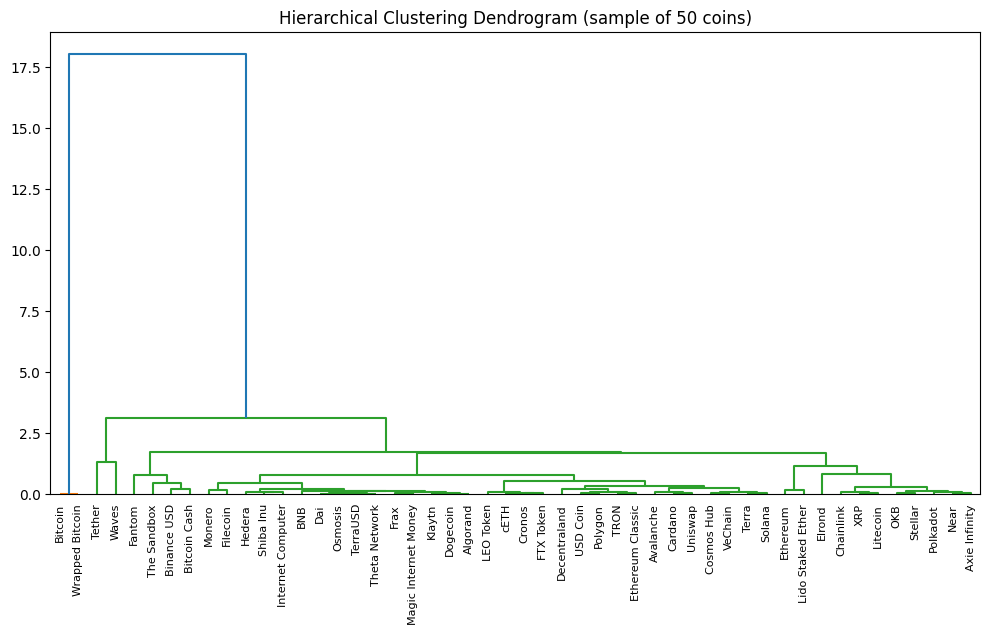

Silhouette Score (Hierarchical): 0.917671228820329


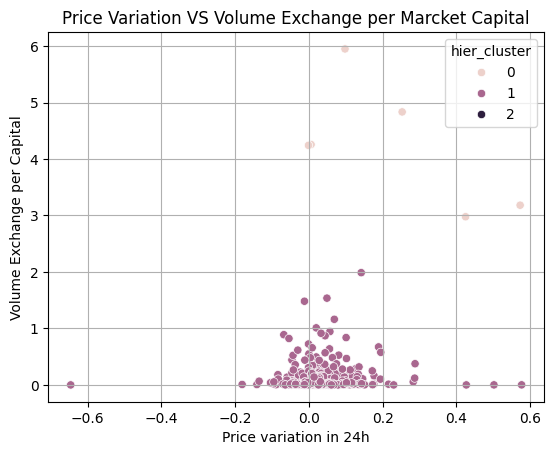

In [13]:

#  Hierarchical Clustering

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Dendrogram (for first 50 coins for readability)
linked = linkage(X_scaled[:50], method='ward')

plt.figure(figsize=(12,6))
dendrogram(linked, labels=df["coin"].values[:50], leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram (sample of 50 coins)")
plt.show()

# Agglomerative clustering (3 clusters)
hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
df["hier_cluster"] = hc.fit_predict(X_scaled)

# Silhouette score
score3 = silhouette_score(X_scaled, df["hier_cluster"])
print("Silhouette Score (Hierarchical):", score3)

plt.Figure(figsize=(12,5))
plt.title('Price Variation VS Volume Exchange per Marcket Capital', loc='center')
sns.scatterplot(data=df, x='24h',y='ratio', hue='hier_cluster')
plt.ylabel('Volume Exchange per Capital')
plt.xlabel('Price variation in 24h')
plt.grid()

plt.show()

In [14]:
df.sort_values('kmeans_cluster', ascending=False).head(15)

,coin,price,1h,24h,7d,24h_volume,mkt_cap,date,ratio,kmeans_cluster,dbscan_cluster,iso_outlier,hier_cluster
186,FLEX Coin,3.970000,0.002,0.006,-0.002,1.326196e+09,3.116005e+08,2022-03-16,4.256079,2,-1,-1,0
407,Alpine F1 Team Fan Token,8.760000,0.003,0.049,1.718,1.535219e+08,9.992220e+07,2022-03-16,1.536414,2,-1,-1,1
182,STEPN,0.534126,0.073,0.573,2.935,1.013705e+09,3.185716e+08,2022-03-16,3.182031,2,-1,-1,0
409,JasmyCoin,0.021232,0.005,0.253,0.913,4.802617e+08,9.936723e+07,2022-03-16,4.833200,2,-1,-1,0
655,STEPN,0.761181,0.013,0.425,4.608,1.358531e+09,4.562513e+08,2022-03-17,2.977594,2,-1,-1,0
692,FLEX Coin,3.950000,-0.000,-0.001,0.006,1.321112e+09,3.115018e+08,2022-03-17,4.241107,2,-1,-1,0
882,Alpine F1 Team Fan Token,10.000000,0.002,0.142,0.953,2.266640e+08,1.140390e+08,2022-03-17,1.987601,2,-1,-1,1
890,JasmyCoin,0.023129,-0.016,0.098,0.685,6.576315e+08,1.105533e+08,2022-03-17,5.948545,2,-1,-1,0
0,Bitcoin,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16,0.045903,1,-1,-1,2
623,renBTC,40854.630000,0.002,0.009,-0.026,1.027536e+07,6.135448e+08,2022-03-17,0.016748,1,-1,-1,2


Here the best model is K-Mean clustering with four cluster

In [16]:
df_clustering = df[['coin', 'price', '1h','24h','7d','24h_volume','mkt_cap','kmeans_cluster']]

df_clustering.to_csv('clustering.csv', index=False)